In [1]:
import pandas as pd
import cv2
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

import pickle
from tqdm.notebook import tqdm


In [2]:
def preprocess_data(directory:str, batch_size:int, test_size:int, rand_num:int, worker:int):
    '''
        directory: the directory of processed directory with class folders inside
        batch_size: size of batch for training
        test_size: percent of dataset used for test
        rand_num: put random number for reproducibility
        worker: number of worker in computation
        
        return train and test data ready for training
    '''
    #pipeline to resize images, crop, convert to tensor, and normalize
    trans = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
    
    dataset = torchvision.datasets.ImageFolder(root=directory, transform=trans) #read image in folder to data with labels
    
    train_len = len(dataset) #get length of whole data
    ind = list(range(train_len)) #indices of whole data
    spl = int(np.floor(test_size * train_len)) #index of test data
    
    #reproducibility and shuffle step
    np.random.seed(rand_num) 
    np.random.shuffle(ind)
    
    #sampling preparation steps
    train_id, test_id = ind[spl:], ind[:spl]
    tr_sampl = SubsetRandomSampler(train_id)
    te_sampl = SubsetRandomSampler(test_id)

    #use data loader to get train and test set ready for training
    trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=tr_sampl,num_workers=worker)
    testloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=te_sampl,num_workers=worker)
    return (trainloader, testloader)

In [ ]:
def switch_layer(pretrained: nn.Module, num_class: int) -> nn.Module:
    """
    Arguments
    ---------
        pretrained : np.array
            A pretrained model
        num_class : int
            The number of classes the classification problem requires.

    Returns:
    --------
        The input pretrained model, but with the last fc layer have the num_class instead
    """

    pretrained.fc = nn.Linear(pretrained.fc.size)


In [3]:
dire = "./Data/Processed" # directory of dataset
# loading data loader
trainloader, testloader = preprocess_data(directory=dire, batch_size=16, test_size=0.3, rand_num=40, worker=4)
# getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16_modules = list(vgg16.children())[:-1]
print(vgg16_modules)
vgg16_model = nn.Sequential(*vgg16_modules)

In [4]:
googlenet = torchvision.models.googlenet(pretrained=True)
googlenet_modules = list(googlenet.children())[:-1]
print(googlenet_modules)
googlenet_model = nn.Sequential(*googlenet_modules)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

[BasicConv2d(
  (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True), BasicConv2d(
  (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), BasicConv2d(
  (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
), MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True), Inception(
  (branch1): BasicConv2d(
    (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch2): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(192, 96, kerne

In [7]:

efficientnet_b7 = torchvision.models.efficientnet_b7(pretrained=True)
efficientnet_b7_modules = list(efficientnet_b7.children())[:-1]
print(efficientnet_b7_modules)
efficientnet_b7_model = nn.Sequential(*efficientnet_b7_modules)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\efficientnet_b7_lukemelas-dcc49843.pth


  0%|          | 0.00/255M [00:00<?, ?B/s]

[Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), b

In [15]:
resnet50 = torchvision.models.resnet50(pretrained=True)
modules = list(resnet50.children())
resnet50.fc = nn.Linear(2048,5)

  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\Admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Epoch:[1/50], training loss: 1.3398
Epoch:[2/50], training loss: 1.0384
Epoch:[3/50], training loss: 0.7239
Epoch:[4/50], training loss: 0.4682
Epoch:[5/50], training loss: 0.3118
Epoch:[6/50], training loss: 0.1780
Epoch:[7/50], training loss: 0.1160
Epoch:[8/50], training loss: 0.0815
Epoch:[9/50], training loss: 0.0705
Epoch:[10/50], training loss: 0.1555
Epoch:[11/50], training loss: 0.0682
Epoch:[12/50], training loss: 0.1089
Epoch:[13/50], training loss: 0.0753
Epoch:[14/50], training loss: 0.0661
Epoch:[15/50], training loss: 0.1041
Epoch:[16/50], training loss: 0.1531
Epoch:[17/50], training loss: 0.0639
Epoch:[18/50], training loss: 0.0341
Epoch:[19/50], training loss: 0.0192
Epoch:[20/50], training loss: 0.0191
Epoch:[21/50], training loss: 0.0119
Epoch:[22/50], training loss: 0.0172
Epoch:[23/50], training loss: 0.0241
Epoch:[24/50], training loss: 0.0573
Epoch:[25/50], training loss: 0.0345
Epoch:[26/50], training loss: 0.0370
Epoch:[27/50], training loss: 0.0272
Epoch:[28/

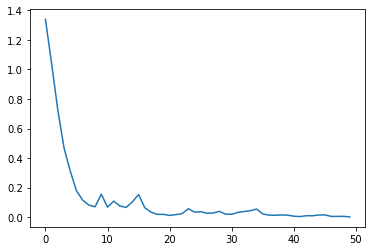

In [16]:
from ipywidgets import IntProgress
#Command out all except one of the below
#net = resnet50
#net = vgg16
#net = googlenet
net = efficientnet_b7

optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
net = net.to(device)
losses = []
epochs = 50
for epoch in tqdm(range(epochs)):  # loop over the dataset multiple times
# YOUR CODE HERE
    Loss = 0.0
    count = 0
    for iter, data in enumerate(trainloader):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        predicted = net(images)
        _, pre1 = torch.max(predicted,dim=1)

        optimizer.zero_grad()
        loss = criterion(predicted, labels)
        loss.backward()
        optimizer.step()

        Loss += loss.item() #accumulate the loss
        count += 1

    avg_loss = Loss/count
    losses.append(avg_loss) #append the average loss for each batch
    print('Epoch:[{}/{}], training loss: {:.4f}'.format(epoch+1, epochs, avg_loss))

    # validation
    if epoch%5==0:
        Loss = 0
        plt.figure(figsize=(10,4))
        with torch.no_grad():
            for iter, data in enumerate(testloader):
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                predicted = net(images)
                _, pre1 = torch.max(predicted,dim=1)

                optimizer.zero_grad()
                loss = criterion(predicted, labels)

                Loss += loss.item() #accumulate the loss
                count += 1
        print('Epoch:[{}/{}], validation loss: {:.4f}'.format(i+1, epochs, Loss))

plt.plot(losses)

In [17]:
correct = 0
total = 0

# YOUR CODE HERE
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        y_hat = net(images)
        max_val, max_i = torch.max(y_hat.data, 1)
        total += labels.size(0)
        correct += (max_i == labels).sum().item()
        
print(f'Accuracy of the network on the 10000 validation x: {100 * correct // total} %')

Accuracy of the network on the 10000 validation x: 57 %
